# **PUC - RIO**
---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1cOhR5ONefKTe9MG7vu-ovTNQ3pgzQws6?usp=sharing)
## MVP
#### Sprint: Análise de Dados e Boas Práticas
#### Autor: Fernando Söndahl Brito

#0. Introdução

> O desenvolvimento do trabalho tem caráter de aprendizado para o desdobramento de melhores práticas para a manipulação e pre-processamento das dados até a implementação de modelos de *machine learning.*

> O trabalho está baseado nos principais indicadores de desenvolvimento nacional dos países que fazem parte da Organização das Nações Unidas (ONU). Para fins do estudo, a escala proposta para o Índice de Desenvolvimento Humano será utilizado como parâmetro para definir a qualidade de vida em cada país.

> Será posto como objetivo, utilizar o aprendizado de máquina para reclassificar o Brasil nessa escala a partir de parâmetros de diferentes categorias, buscando entender em quais pontos o País precisa se desenvolver para incrementar seu IDH.

> Uma aplicação não habitual, onde não se irá predizer o resultado de novos registros de acordo com o aprendizado, esse trabalho irá usar dos modelos de classificação para realizar um *benchmarking* entre os diversos países. Como a modelagem em si não é o principal objetivo do estudo, reserva-se esse fim acadêmico para uma modelagem que não terá grande força de escabilidade e replicação, mas apenas para gerar conhecimento acerca do *status* brasilero perante o desenvolvimento das demais nações do mundo.

> Todos os modelos implementados serão baseados nas classificações estabelecidas pelo Programa das Nações Unidas para o Desenvolvimento (PNUD): Muito alto, Alto, Médio e Baixo; acerca do nível de desenvolvimento. Sendo já conhecidos e utilizados como atributo alvo (*target*) de todas as classificações, serão portanto realizados aprendizados supervisionados.

# 1. Importação das Bibliotecas utilizadas

In [1]:
!pip install geopandas

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import io
import itertools

import requests
import tempfile

import shapely

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patheffects as pe
import seaborn as sns


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# 2. Conexão e tratamento dos dados

## 2.1 *World Data dataset*

> O primeiro *dataset* utilizado traz a lista dos países da ONU e uma série de indicadores sobre saúde, meio-ambiente, economia e o IDH (em inglês Human Development Index HDI) de cada um.

> O arquivo .CSV está disponível em [github/fersondahl/world-data](https://github.com/fersondahl/PUC_DScience_sprint1/blob/2fe5c984cae3fffbd73d8cfcb45833c470851380/world-data-2023.csv).

In [3]:
countries = pd.read_csv("https://raw.githubusercontent.com/fersondahl/PUC_DScience_sprint1/main/world-data-2023.csv")


countries.info()
countries.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    193 non-null    object 
 1   Density
(P/Km2)                            193 non-null    object 
 2   Abbreviation                               187 non-null    object 
 3   Agricultural Land( %)                      187 non-null    object 
 4   Land Area(Km2)                             192 non-null    object 
 5   Armed Forces size                          170 non-null    object 
 6   Birth Rate                                 188 non-null    float64
 7   Calling Code                               192 non-null    float64
 8   Capital/Major City                         190 non-null    object 
 9   Co2-Emissions                              187 non-null    object 
 10  CPI                       

,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude,HDI
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953,0.478
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331,0.796
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626,0.745
3,Andorra,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,469,...,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801,0.858
4,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,"34,693",...,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887,0.586


> Verificando as linhas iniciais e a descrição dos dados, é possível perceber uma grande ocorrência de erros de tipagem dos dados.

> Pode se atestar que a decorrência disso é fruto da presença dos separadores de milhar, e o uso dos símbolos percentuais e cifrão junto aos números. Isso faz com que esses dados sejam interpretados como textos.

> Para que esse problema possa ser resolvido, todos os conjuntos identificados como númericos terão retirados os seus separadores de milhar e seus respectivos símbolos. Após isso, serão todos convertidos para o tipo numérico *float*.

> Será criada também um coluna chamada *geometry*, para que possam ser feitas análises geo-espaciais. Para isso será utilizada a classe *point* da biblioteca *shapely*, unindo os registros de latitude e longitude.

In [4]:
for col in ['Density\n(P/Km2)', 'Land Area(Km2)', 'CPI', 'Armed Forces size', 'Co2-Emissions', 'Population', 'Population', 'GDP', 'Urban_population', 'Gasoline Price', 'Minimum wage', 'Physicians per thousand']:
  countries[col] = countries[col].apply(lambda linha: linha.replace(",", "").replace("$", "") if type(linha) == str else linha).astype(float)

#percents columns
for col in list(filter(lambda elem: "%" in elem, countries.columns)) + ['Total tax rate', 'Unemployment rate', 'Out of pocket health expenditure']:
  countries[col] = countries[col].apply(lambda linha: float(linha.replace(",", "").replace("%", ""))/100 if type(linha) == str else linha).astype(float)


countries['geometry'] = list(map(lambda lng, lat: shapely.geometry.Point(lat, lng), countries['Latitude'], countries['Longitude']))


countries['HDI_level'] = np.where(countries['HDI'] >=.8, "very high",
                        np.where(countries['HDI'] >=.7, "high",
                        np.where(countries['HDI'] >=.55, "medium", 'low'
                                  )))

countries.head()

,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude,HDI,geometry,HDI_level
0,Afghanistan,60.0,AF,0.581,652230.0,323000.0,32.49,93.0,Kabul,8672.0,...,0.489,0.093,0.714,0.1112,9797273.0,33.939110,67.709953,0.478,POINT (67.709953 33.93911),low
1,Albania,105.0,AL,0.431,28748.0,9000.0,11.78,355.0,Tirana,4536.0,...,0.557,0.186,0.366,0.1233,1747593.0,41.153332,20.168331,0.796,POINT (20.168331 41.153332),high
2,Algeria,18.0,DZ,0.174,2381741.0,317000.0,24.28,213.0,Algiers,150006.0,...,0.412,0.372,0.661,0.1170,31510100.0,28.033886,1.659626,0.745,POINT (1.659626 28.033886),high
3,Andorra,164.0,AD,0.400,468.0,NaN,7.20,376.0,Andorra la Vella,469.0,...,NaN,NaN,NaN,NaN,67873.0,42.506285,1.521801,0.858,POINT (1.521801 42.506285),very high
4,Angola,26.0,AO,0.475,1246700.0,117000.0,40.73,244.0,Luanda,34693.0,...,0.775,0.092,0.491,0.0689,21061025.0,-11.202692,17.873887,0.586,POINT (17.873887 -11.202692),medium


# 2.2 Mapa Mundi

> Já o segundo *dataset* traz informações espaciais sobre os limites geográficos de cada país, o que possibilitará a plotagem dos atributos.

> O conjunto de dados tem um número maior de registros por separar territórios que fazem parte de outros Estados, e também países que não fazem parte da ONU. De toda maneira, os dados contidos no *dataset* ***world data*** é que serão avaliados preferencialmente.

> O arquivo .geojson está disponível em [github/fersondahl/world-administrative-boundaries](https://github.com/fersondahl/PUC_DScience_sprint1/blob/2fe5c984cae3fffbd73d8cfcb45833c470851380/world-administrative-boundaries.geojson).

In [5]:
mundi_map = gpd.read_file("https://raw.githubusercontent.com/fersondahl/PUC_DScience_sprint1/main/world-administrative-boundaries.geojson").set_crs('4326')[['name', 'continent', 'geometry']]
mundi_map

,name,continent,geometry
0,Northern Mariana Islands,Oceania,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ..."
1,Kuril Islands,Asia,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ..."
2,France,Europe,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6..."
3,Serbia,Europe,"POLYGON ((20.26102 46.11485, 20.31403 46.06986..."
4,Uruguay,Americas,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7..."
...,...,...,...
251,Albania,Europe,"POLYGON ((20.07142 42.56091, 20.10208 42.53347..."
252,Gibraltar,Europe,"POLYGON ((-5.35580 36.16331, -5.33451 36.16256..."
253,New Zealand,Oceania,"MULTIPOLYGON (((169.18552 -52.57695, 169.16166..."
254,Madeira Islands,Europe,"POLYGON ((-17.10250 32.82333, -17.05306 32.809..."


In [19]:
related = pd.merge(left=countries, right=mundi_map.rename(columns={'name':'Country'}), how='left', on='Country', indicator=True)

f"Total de apenas {str(round(related['_merge'].value_counts().both/len(countries)*100, 2))}% dos dados categorizados"

'Total de apenas 87.56% dos dados categorizados'

> Um dos desafios encontrados para unir os dados é a falta de padrão para o registro do nome de cada país.

> Como já se tem informações espaciais em cada *dataset*, optou-se por realizar o relacionamento através de testes de geolocalização. O ponto de cada país será testado em cada polígono, até que saiba dentro de qual camada ele está.

> Por precisão, alguns pontos não foram classificados diretamente, mas para esses casos foi considerada a camada mais próxima que ainda não havia sido selecionada.

In [7]:
#### RELACIONAR POLÍGONOS E INFORMAÇÕES DOS PAÍSES

relac_cnt_map = {}

for ind, cnt in countries.iterrows():
  for ind_m, loc in mundi_map.iterrows():
    if loc['geometry'].contains(cnt['geometry']):
      relac_cnt_map.update({loc['name']: ind})
      break

if len(countries) != len(relac_cnt_map):
  pending_pols = {}
  for ind, cnt in countries[pd.Series(countries.index).isin(list(relac_cnt_map.values())) == False].iterrows():
    for ind_m, loc in mundi_map[mundi_map['name'].isin(list(relac_cnt_map.keys())) == False].iterrows():
        pending_pols.update({(ind, ind_m):{'distance':loc['geometry'].distance(cnt['geometry']), 'Country':ind, 'c_name':cnt['Country'], 'map':loc['name']}})

  adjust = pd.DataFrame(pending_pols).T.reset_index(drop=True)

  adjust = pd.merge(left=adjust, right=adjust.groupby('Country').agg({'distance':min}).reset_index(),
          on=['Country', 'distance'], how='right')

adjust

,distance,Country,c_name,map
0,0.125779,29,Cape Verde,Cape Verde
1,0.067362,54,Eritrea,Eritrea
2,0.25391,103,Maldives,Maldives
3,0.174082,106,Marshall Islands,Marshall Islands
4,7.585693,110,Federated States of Micronesia,Micronesia (Federated States of)
5,0.002264,112,Monaco,Monaco
6,0.085158,122,New Zealand,New Zealand
7,0.288118,137,Philippines,Philippines
8,0.174905,146,Saint Vincent and the Grenadines,Saint Vincent and the Grenadines
9,0.083335,147,Samoa,Samoa


In [8]:
relac_cnt_map.update(adjust.set_index('map')['Country'].to_dict())
mundi_map['ind_code'] = mundi_map['name'].apply(lambda linha: relac_cnt_map[linha] if (linha in list(relac_cnt_map.keys())) else np.nan)

cnt_map = gpd.GeoDataFrame(pd.merge(left=countries.rename(columns={'geometry':'point'}), right=mundi_map.dropna(subset='ind_code').set_index('ind_code').drop('name', axis=1),
         left_index=True, right_index=True, how='left')).set_geometry('geometry')

cnt_map = cnt_map.set_index('Country').sort_values('HDI')

cnt_map['geometry'].info()

<class 'geopandas.geoseries.GeoSeries'>
Index: 193 entries, Somalia to Switzerland
Series name: geometry
Non-Null Count  Dtype   
--------------  -----   
193 non-null    geometry
dtypes: geometry(1)
memory usage: 7.1+ KB


> Por fim, foi possível relacionar 100% das informações, ficando clara a robustez do processo de relacionamento através das características geo-espaciais, gerando o *DataFrame* ***cnt_map***.

> Para os poucos casos que precisaram de classificação por distância, foi possível rapidamente avaliar a precisão da alternativa. Além disso, atesta-se o preenchimento dos dados da Micronesia, que não teria suas informações de limite administrativo caso fosse optado por um *merge* com o nome do país.

# 3. Distribuição do IDH pelo mundo

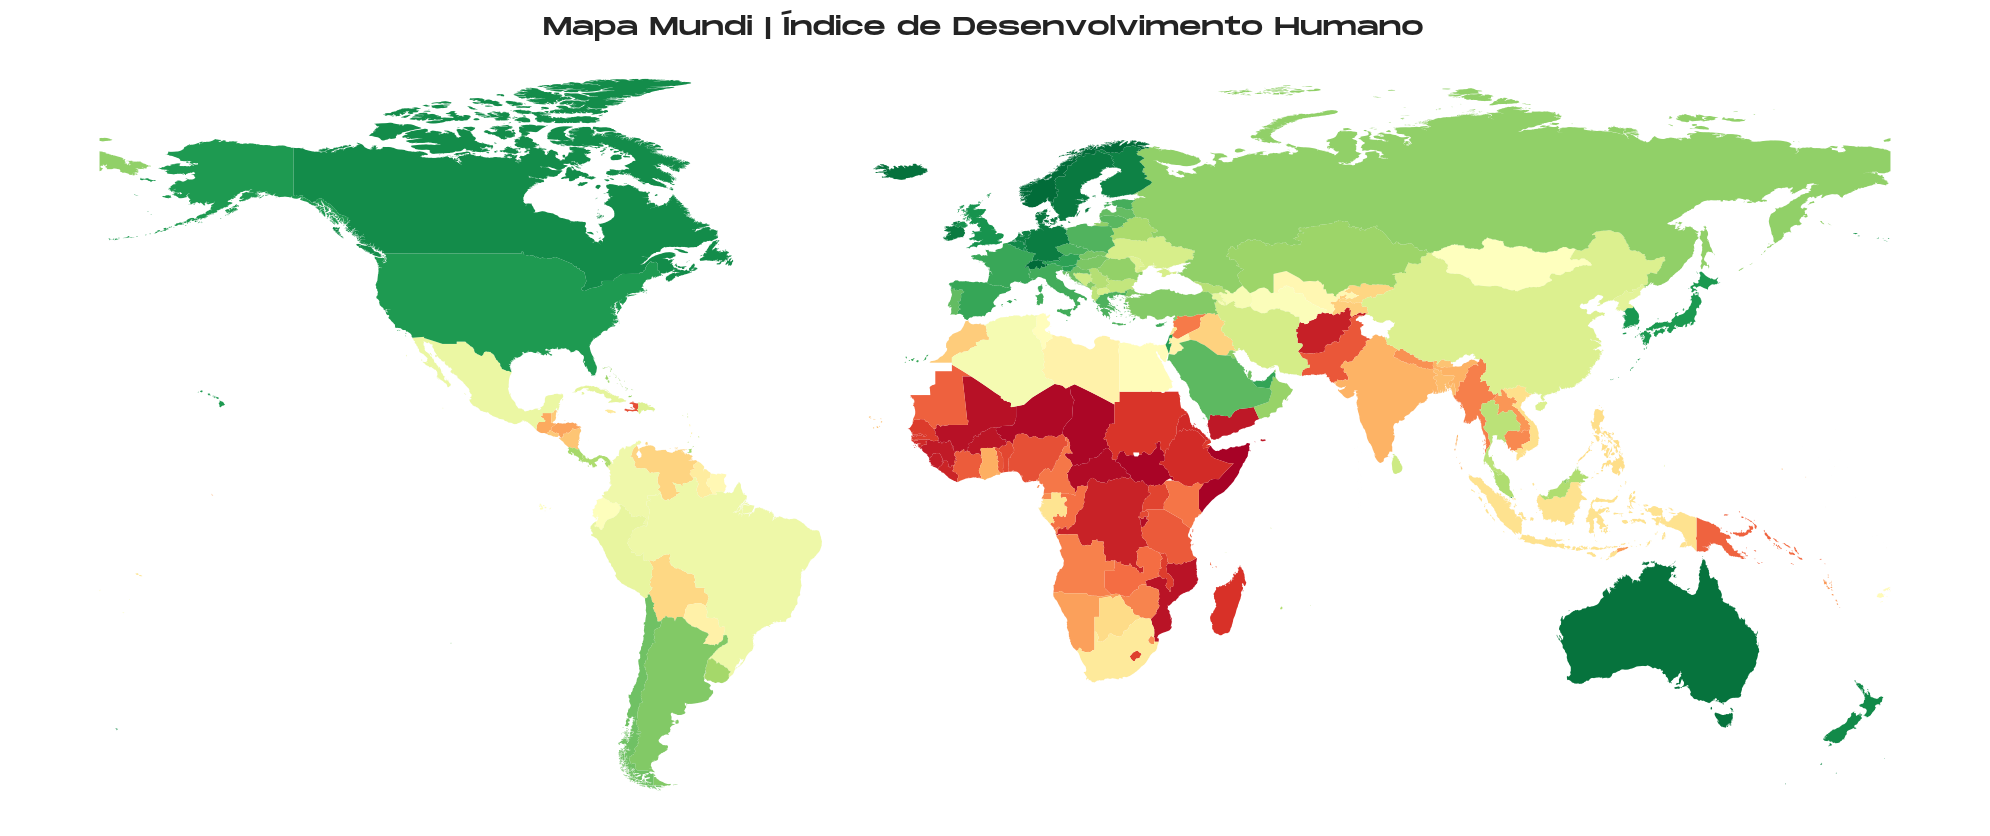

In [9]:
cnt_map['color'] = sns.color_palette('RdYlGn', n_colors=len(cnt_map)).as_hex()

### FONT IMPORT
github_url = 'https://github.com/fersondahl/PUC_DScience_sprint1/raw/main/Monument%20Extended.otf'
response = requests.get(github_url)

buf = io.BytesIO()

buf.write(response.content)


with tempfile.NamedTemporaryFile(delete=False) as temp_file:
    temp_file.write(buf.getvalue())
    file_path = temp_file.name

title_font = fm.FontProperties(fname=file_path)

with sns.axes_style({'axes.facecolor': '#00000000', 'axes.edgecolor': '#00000000',
   'xtick.bottom': False, 'xtick.top': False, 'ytick.left': False, 'ytick.right': False,}):

    fig, ax = plt.subplots()

    cnt_map.plot(ax=ax, color=cnt_map['color'], lw=0)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    sns.despine(bottom=True, left=True)

    ax.set_title("Mapa Mundi | Índice de Desenvolvimento Humano  ", fontproperties=title_font, color='#232323', size=18)


    fig.set_figheight(10, forward=True)
    fig.set_figwidth(20, forward=True)

    fig.tight_layout()


> É possível perceber a relação espacial da distribuição do IDH pelo mundo. Os países de destaque estão localizadas na América do Norte, Europa e os maiores países da Oceania. O restante da América e boa parte da Ásia reserva os níveis médios de desenvolvimento e os piores índices estão majoritariamente na África.

> Essa avaliação será importante para o tratamento dos dados a seguir.

# 4. Limpeza dos dados, Pré-Processamento e instanciação do modelo

## 4.1 Limpeza dos *missings*

> Os atributos utilziados no modelo serão todos numéricos, e a estratégia adotada para o preenchimento dos valores faltantes será o uso da média.

> Contudo, considerando que países próximos geograficamente em geral têm características parecidas, o preenchimento dos atributos será dado a partir da média dos países vizinhos.

> Caso não haja país vizinho, ou se os vizinhos também apresentarem valores faltantes, será então utilizada a média global.

> O *DataFrame* ***mean_df*** relaciona cada país com seus vizinhos geográficos.

In [10]:
ngb_def = cnt_map.copy()[['geometry']]

neighbor = {}

## Define países vizinhos de cada país
for ind_org, geom_org in ngb_def.iterrows():
  neighbor.update({ind_org:[ngb_def[ngb_def['geometry'].apply(lambda linha: linha.touches(geom_org['geometry']))].index.to_list()]})

mean_df = pd.DataFrame(neighbor, index=['ngb']).T

mean_df

,ngb
Somalia,"[Ethiopia, Djibouti, Kenya]"
South Sudan,[]
Chad,"[Niger, Central African Republic, Nigeria, Cam..."
Niger,"[Chad, Mali, Burkina Faso, Benin, Nigeria, Lib..."
Central African Republic,"[Chad, Democratic Republic of the Congo, Repub..."
...,...
Australia,[]
Iceland,[]
Monaco,[France]
Norway,"[Russia, Finland, Sweden]"


Por fim, será gerado um novo *DataFrame* ***treated_countries***, com todas as colunas númericas do df original (cnt_map) integralmente preenchidas

In [11]:
## Seleção das colunas númericas e com valores faltantes
data_status = pd.concat([cnt_map.dtypes.reset_index().rename(columns={'index':'column', 0:'type'}),
                         cnt_map.count().reset_index().rename(columns={0:'n_values'})[['n_values']]], axis=1)

num_falt = data_status[(data_status['type'] == float) & (data_status['n_values'] != len(cnt_map))].column.to_list()

treated_countries = cnt_map.copy()
## Substitui valores faltantes pela média dos vizinhos
for col in num_falt:
  treated_countries[col] = treated_countries[col].fillna(mean_df['ngb'].apply(lambda linha: cnt_map.loc[linha][col].mean() if (
      len(pd.Series(cnt_map.loc[linha][col]).dropna()) > 0) else cnt_map[col].mean()))

treated_countries.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, Somalia to Switzerland
Data columns (total 40 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   Density
(P/Km2)                            193 non-null    float64 
 1   Abbreviation                               187 non-null    object  
 2   Agricultural Land( %)                      193 non-null    float64 
 3   Land Area(Km2)                             193 non-null    float64 
 4   Armed Forces size                          193 non-null    float64 
 5   Birth Rate                                 193 non-null    float64 
 6   Calling Code                               193 non-null    float64 
 7   Capital/Major City                         190 non-null    object  
 8   Co2-Emissions                              193 non-null    float64 
 9   CPI                                        193 non-null    float64 
 1

## 4.2 Pré-Processamento e instanciação do modelo

> Serão feitos diferentes modelos para diferentes classes de atributos. Foram escolhidas 4 categorias para avaliar o posicionamento do desenvolvimento brasileiro, sendo elas as seguintes caracterísicas: População, Economia, Condições de Trabalho e Saúde.

> Como estão sendo considerados atributos de diferentes nações em contextos absolutamente diferentes, ao invés de um processo com uma variabilidade mapeada, é não somente difícil imaginar que os dados apresentem uma distribuição normal, como tampouco saber ao certo a que distribuição pertencem. Por conta disso, os dados serão sempre pre-processados utilizando a normalização, implementada através do **MinMaxScaler()**.


> Tanto as etapas de pré-processamento como o modelo em si foram instanciados na *function* ***category_model_results***, atributo da *class* ***models_apply***. Dessa maneira, é mais fácil personalizar quais atributos farão parte de cada categoria de avaliação e replicar o modelo com as mesmas premissas para cada uma dessas categorias. O parâmetro de instanciação da classe será justamente o país a ser comparado com os demais.

> Para as classificações foi utilizado o modelo de ***Random Forest***, para determinar qual a escala de desenvolvimento humano o país analisado tem em cada categoria de atributos.

> Foi definida também a *function* ***exp_outlier*** para que seja possível retirar os *outliers* de cada atributo. A eliminação é feita através da avaliação do primeiro e terceiro quartil da amostra, que definem o intervalo interquartílico (IQR). Serão somente considerados os dados que atendam às seguintes restrições: *X* > $Q_1$ - 1,5(IQR) e *X* < $Q_3$ + 1,5(IQR)

In [12]:
def exp_outlier(dataset: pd.Series, cut_index=1.5):
  q_1, q_3 = np.quantile(dataset, .25), np.quantile(dataset, .75)
  iqr = q_3 - q_1

  return list(map(lambda elem: "normal" if (elem >= (q_1 - iqr*cut_index)) & (elem <= (q_3 + iqr*cut_index)) else "outlier", dataset))


class models_apply(object):


  def __init__(self, obj_target):

    self.models_attributes = {

      'populational':['Gross tertiary education enrollment (%)', 'Physicians per thousand'],

      'economic':['CPI Change (%)', 'GDP', 'Tax revenue (%)'],

      'work_conditions':['Unemployment rate', 'Minimum wage'],

      'health':['Maternal mortality ratio', 'Out of pocket health expenditure', 'Infant mortality'],
      }


    results = {}
    for key in self.models_attributes.keys():
      results.update({key : self.category_model_results(key, obj_target)})

    self.results = results


  def category_model_results(self, col, objective):

    features = treated_countries.loc[list(filter(lambda elem: elem.lower() != objective.lower(), treated_countries.index))] # O país é retirado da amostra para não corromper a aprendizagem

    for attribute in self.models_attributes[col]:

      features['outlier_detect'] = exp_outlier(features[attribute])
      features = features[features['outlier_detect'] == "normal"]

    X_train, X_test, y_train, y_test = train_test_split(features[self.models_attributes[col]], features['HDI_level'], test_size=.3, random_state=12) # separação das amostras de treino e teste

    scaler_train = MinMaxScaler()

    scaler_train.fit(X_train) #normalização da amostra de treino

    rf = RandomForestClassifier(random_state=12)
    rf.fit(scaler_train.transform(X_train), y_train)

    scaler_test = MinMaxScaler()
    scaler_test.fit(X_test) #normalização da amostra de teste

    prediction = rf.predict(scaler_test.transform(X_test))


    obj_prd = pd.DataFrame(treated_countries.loc[objective]).loc[self.models_attributes[col]].T
    scaler_train.fit(obj_prd)
    result = rf.predict(scaler_train.transform(obj_prd))

    return result[0], accuracy_score(prediction, y_test)

br_status = models_apply('Brazil')

## 4.3 Dispersão dos atributos

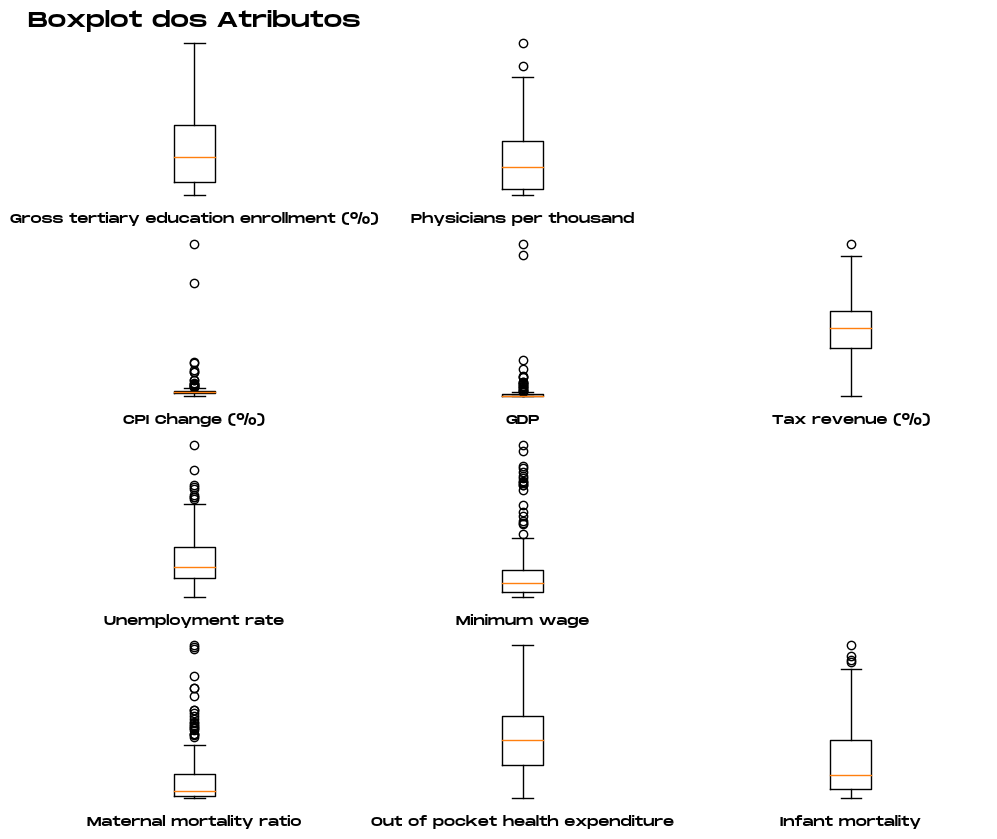

In [13]:
attributes = br_status.models_attributes

with sns.axes_style({'axes.facecolor': '#00000000', 'axes.edgecolor': '#00000000',
  'xtick.bottom': False, 'xtick.top': False, 'ytick.left': False, 'ytick.right': False}):
    fig, axs = plt.subplots(len(attributes), max(list(map(lambda elem: len(elem), list(attributes.values())))))

    for categ in attributes.keys():
      for atb in attributes[categ]:

        axs[list(attributes.keys()).index(categ), list(attributes[categ]).index(atb)].boxplot(treated_countries[atb], labels=[atb])
        axs[list(attributes.keys()).index(categ), list(attributes[categ]).index(atb)].set_yticklabels([])

        for ind, label in enumerate(axs[list(attributes.keys()).index(categ), list(attributes[categ]).index(atb)].get_xticklabels()):
          label.set_font(title_font)
          label.set_size(9)

    for i in range(len(attributes)):
      for j in range(max(list(map(lambda elem: len(elem), list(attributes.values()))))):
        if axs[i,j].get_yticklabels()[0].get_text() != "":
          axs[i,j].set_xticklabels([])
          axs[i,j].set_yticklabels([])

    axs[0,0].set_title("Boxplot dos Atributos", fontproperties=title_font, size=15)

    fig.set_figheight(10, forward=True)
    fig.set_figwidth(12, forward=True)


> Avaliando separadamente cada atributo, é possível perceber que em muitos deles há uma quantidade razoável de *outliers*, o que justifica a necessidade de se fazer esse tipo de tratamento.

> Dessa maneira, será possível encontrar uma distribuição mais limpa após a realização da normalização. Sem esse processo, os valores extremamente altos faria com que a grande maioria dos dados do atributo se aproximassem de 0.

#5. Resultados

## 5.1 Previsões geradas pelo modelo:

In [14]:
pd.DataFrame(br_status.results).T.rename(columns={0:'predict', 1:'accuracy'}).sort_values('accuracy', ascending=False)

,predict,accuracy
health,very high,0.76
populational,low,0.614035
work_conditions,low,0.42
economic,medium,0.377778


## 5.2 Gráfico radar | Status Brasil

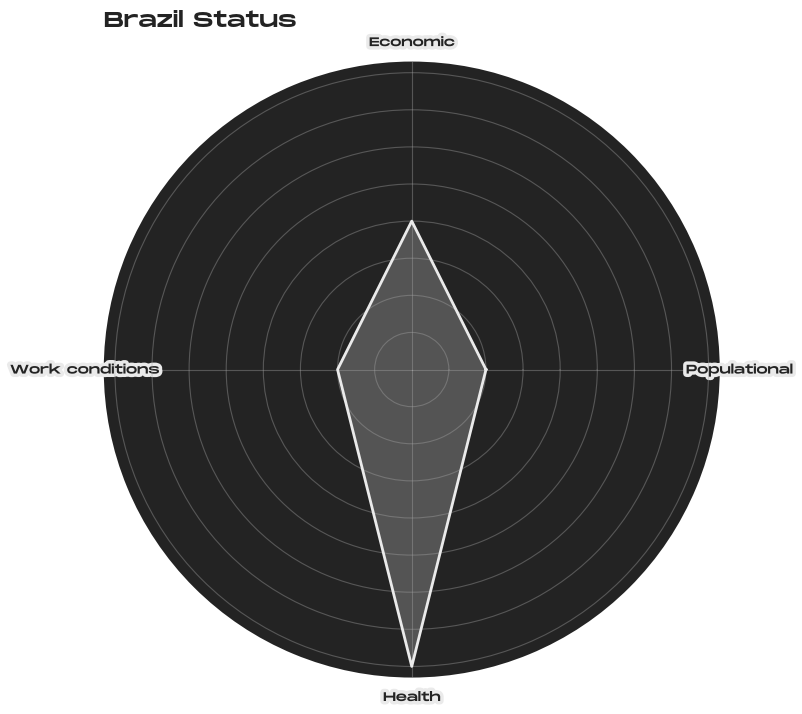

In [15]:
categories = list(br_status.results.keys())

scale_status = {"very high":4, "high":3, "medium":2, 'low':1}


values = list(map(lambda elem: scale_status[elem[0]], br_status.results.values()))


with sns.axes_style({'axes.facecolor': '#232323', 'axes.edgecolor': '#232323',
  'xtick.bottom': False, 'xtick.top': False, 'ytick.left': False, 'ytick.right': False}):
    fig, ax = plt.subplots(subplot_kw=dict(polar=True))


    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    ax.fill(angles, values, color='#EAEAEA', alpha=0.25)
    ax.plot(angles, values, color='#EAEAEA', linewidth=2)


    # Label each axis
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(list(map(lambda elem: elem.replace("_", " ").capitalize(), categories)), fontproperties=title_font, size=9, color='#232323',
                      path_effects=[pe.withStroke(foreground="#EAEAEA", linewidth=5)])

    ax.set_yticklabels([])

    ax.grid(alpha=.4, color='#A5A5A5')

    ax.spines['polar'].set_alpha(0)

    # Add a title
    ax.set_title('Brazil Status ', color='#232323', fontproperties=title_font, loc='left', size=15)

    fig.set_figheight(8, forward=True)
    fig.set_figwidth(8, forward=True)

> O resultado do trabalho demonstra que, em comparação às demais nações da ONU, o Brasil se posiciona entre os países altamente desenvolvidos somente no quesito de saúde. Mesmo que ainda haja bastante coisa a ser feita, o acesso à saúde fornecido pelo SUS e os reduzidos índices de mortalidade infantil e materna corroboram para o destaque.

> Foi alcançado um nível médio na economia nacional.

> Os destaques negativos, que necessitam maior atenção do país é o desenvolvimento da população e das condições de trabalho.

#6. Conclusão

> Por mais que um estudo focado em instrumentos de transformação e pré-processamento dos dados, foram geradas hipóteses acerca do desenvolvimento do Brasil em diferentes categorias.

> Estudo posteriores poderiam corroborar com os dados aqui gerados, e buscar através de *benchmarkings*, quais pontos são causa do resultado negativo e depreender quais ações são necessárias para que o país alcance níveis melhores de desenvolvimento.

> As modelagens aplicadas através do *Random Forest* ainda apresentaram índices baixos de acurácia. Como ainda não era o foco do estudo, foi suficiente para a aplicação do aprendizado e a geração das hipóteses. Ainda assim, a remodelaagem do problema é importante para que se dê mais robustez às informações geradas.

> Um dos pontos negativos do IDH, que aqui foi utilizado como régua para a qualidade do desenvolvimento (classe/*target*), é se restringir a poucos parâmetros para inferir o nível de desenvolvimento nacional. Pelo estudo foi possível observar que as categorias que têm atributos com maior correlação com os indicadores utilizados no cálculo do IDH tiveram maior acurácia na implementação da modelagem. O dado reforça o fato de se ter uma medição mais abrangente dos aspectos nacionais para a definição do nível de desenvolvimento.